# Cluster Scale section ...

In [1]:
from dask_jobqueue import SLURMCluster
from dask.distributed import Client
import dask
import os
import sys
import uuid

### Add proxy binaries to path

In [2]:
pwd = !echo ${PWD}

### Extend the local python paths with some network drives

In [3]:
extension_python_paths = ['/datasets/work/oa-roamsurf/work/cmextremes_py/extraction/', os.environ["HOME"] + '/lib/python3.8/site-packages']
[sys.path.append(an_ext) for an_ext in extension_python_paths]

[None, None]

### Specify a python exe used by SLURM to create the dask workers


In [4]:
containered_python_exe = f"srun --export=ALL -n $SLURM_NTASKS -c $SLURM_CPUS_PER_TASK   singularity run {os.environ['SINGULARITY_CONTAINER']} python"

### If you run this cell after creating a cluster it will close that cluster 

In [5]:
try:
    cluster.close()
except:
    pass

### Create a cluster
env_extra sets the worker specific environment parameters   

PYTHONPATH is set to include the extension ptyhon paths and the SINGULARITY_BINDPATH bind paths of this jupyter environment for passing to the workers

In [6]:
job_suffix = os.environ['JOB_SUFFIX'] if 'JOB_SUFFIX' in os.environ.keys() else str(uuid.uuid4())[:8]

## List available project codes

In [7]:
!get_project_codes

/bin/bash: line 1: get_project_codes: command not found


In [8]:
# defined = 'NC_IN_GLOB' in os.environ.keys()
# if not defined:
#     print("WARNING, project code note defined defaulting")
#     project_code = 'OD-215204'
# else:
#     project_code = os.environ['NC_IN_GLOB']

# OD-229130	2023-12-31	Van KIRAP 2.0: GCF Vanuatu Climate Information Services for Resilient Development
project_code = 'OD-229130'

In [9]:
job_extra = f'--account {project_code}'

In [10]:
process_number = 2

In [11]:
cluster = SLURMCluster(
    cores=8, memory="96G", processes=process_number,
    walltime="02:00:00",
    interface='ib0',
    death_timeout=480,
    job_name = f'dask-worker-{job_suffix}',
    job_extra = [job_extra],
    env_extra=[
              'module load singularity', # ensure singularity is loaded
              'export PYTHONPATH=' + ':'.join(extension_python_paths),
              'export SINGULARITY_BINDPATH=' + os.environ['SINGULARITY_BIND'], 
              'export SINGULARITYENV_PREPEND_PATH='+ str(pwd[0]) +':' + str(pwd[0]) + ',/srv/conda/envs/notebook/bin:/srv/conda/condabin:/srv/conda/bin'],
    extra = [f'--local-directory={os.environ["SCRATCH3DIR"]}'],
    python=containered_python_exe,  # use pyhton in container
)

# Debug by running cluster.job_script()

/srv/conda/envs/notebook/lib/python3.10/site-packages/dask_jobqueue/core.py:237: FutureWarning: extra has been renamed to worker_extra_args. You are still using it (even if only set to []; please also check config files). If you did not set worker_extra_args yet, extra will be respected for now, but it will be removed in a future release. If you already set worker_extra_args, extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask_jobqueue

## if running a single process based cluster something like this might be needed
```
cluster = SLURMCluster(
    cores=1, memory="24G", processes=1,
    walltime="01:59:00",
    interface='ib0',
    death_timeout=480,
    nanny=False,
    job_name = f'dask-worker-{job_suffix}',
    job_extra = [job_extra],
    extra = [f' --local-directory={os.environ["SCRATCH2DIR"]}'],
    env_extra=[
    'module load singularity', # ensure singularity is loaded
    'export PYTHONPATH=' + ':'.join(extension_python_paths),
    'export SINGULARITY_BINDPATH=' + os.environ['SINGULARITY_BIND'],
    'export SINGULARITYENV_PREPEND_PATH='+ str(pwd[0]) +':' + str(pwd[0]) + ',/srv/conda/envs/notebook/bin:/srv/conda/condabin:/srv/conda/bin'],
    python=containered_python_exe, # use pyhton in container    
)
```

### Create a client, this will inject dask into xarray and the distributed cluster into dask

In [12]:
client = Client(cluster, timeout=240)
display(client)

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://10.150.202.157:8787/status,
Dashboard: http://10.150.202.157:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.150.202.157:38521,Workers: 0
Dashboard: http://10.150.202.157:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [13]:
port = client.dashboard_link.split('/')[-2].split(':')[-1]
print(f"Try http://localhost:8888/proxy/{port}/status for the dask dashboard")

Try http://localhost:8888/proxy/8787/status for the dask dashboard


### Scale your workers

With the default config in SLURMCluster above each job will get create 2 workers, one per process and each will have 30gb ram and 4 cores

In [14]:
max_workers = 8

import time
for i in range(0, max_workers): 
    cluster.scale(jobs=i) #yes this looks weird requesting n+1 workers everytime but really it only requests 1 new worker each time
    time.sleep(5)

timeout = 600   # seconds till timeout, timeout if cluster not up in 10 minutes
timeout_start = time.time()
while len(client.ncores().keys())*process_number < max_workers -1:
    if (time.time() > timeout_start+timeout):
        raise Exception(f"Failed to start enough workers in {timeout} seconds, {len(cluster.workers)} started")
    time.sleep(1)

/srv/conda/envs/notebook/lib/python3.10/site-packages/dask_jobqueue/core.py:237: FutureWarning: extra has been renamed to worker_extra_args. You are still using it (even if only set to []; please also check config files). If you did not set worker_extra_args yet, extra will be respected for now, but it will be removed in a future release. If you already set worker_extra_args, extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask_jobqueue

In [15]:
len(client.ncores())

10

# "Normal" notebook cells to do the work ...

In [16]:
import sys
from datetime import datetime
import numpy as np
import pandas as pd
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import xarray as xr
import re
import glob

In [17]:
# # only run this if above dask cluster cells are notrun
# # comment out otherwise
# from dask.distributed import Client, LocalCluster 
# cluster = LocalCluster() # Launches a scheduler and workers locally 
# client = Client(cluster)

In [18]:
# get some pre-defined functions
# probably want to move them somewhere better more accessible
base_path = '/datasets/work/oa-vankirap/work/'
sys.path.append(f'{base_path}/bin/')
from SCHISM_load_plot_defs import schism_load, find_nearest_wet_point, schism_plot

In [19]:
# set path where individual "tile" files will be stored:
# scratch_path = '/scratch1/hoe01e/vankirap'
scratch_path = '/scratch3/hoe01e/vankirap'

## Part 1: "Tile" Entire hincast dataset, saving output to scratch as N "tiles" concanated in time 

### Open the entire VanKIRAP Hindcast_v3 elev, hs variables as dataset

In [20]:
# sc_2016, meshtri = schism_load(f'{base_path}/schism/Hindcast_v2/schout_2015_elev_hs.nc')
# sc_2016 = xr.open_dataset(f'{base_path}/schism/Hindcast_v2/schout_2015_elev_hs.nc', chunks={'time': 8760/8})
# sc_ds = xr.open_mfdataset(f'{base_path}/schism/Hindcast_v2/schout_*_elev_hs.nc', chunks={'time': 8760/2, })
# files = glob.glob(f'{scratch_path}/Hindcast_v3/schout_*_elev_hs.nc')
files = glob.glob(f'{base_path}/schism/Hindcast_v3/schout_*_elev_hs.nc')
# sc_ds = xr.open_mfdataset(files[0:3], chunks='auto')
sc_ds = xr.open_mfdataset(files, chunks='auto')
for var in ['SCHISM_hgrid_face_nodes','SCHISM_hgrid_node_x','SCHISM_hgrid_node_y','depth']:
    sc_ds[var]=sc_ds[var].isel(time=0)

In [21]:
# drop elev, since we are only interested in Hs
sc_ds=sc_ds.drop('elev')
sc_ds

<xarray.Dataset>
Dimensions:                  (time: 359424, nSCHISM_hgrid_node: 100927,
                              nSCHISM_hgrid_face: 201374,
                              nMaxSCHISM_hgrid_face_nodes: 4, one: 1)
Coordinates:
  * time                     (time) datetime64[ns] 1980-01-01T01:00:00 ... 20...
Dimensions without coordinates: nSCHISM_hgrid_node, nSCHISM_hgrid_face,
                                nMaxSCHISM_hgrid_face_nodes, one
Data variables:
    hs                       (time, nSCHISM_hgrid_node) float32 dask.array<chunksize=(1708, 19644), meta=np.ndarray>
    SCHISM_hgrid_face_nodes  (nSCHISM_hgrid_face, nMaxSCHISM_hgrid_face_nodes) float64 dask.array<chunksize=(201374, 4), meta=np.ndarray>
    SCHISM_hgrid_node_x      (nSCHISM_hgrid_node) float64 dask.array<chunksize=(100927,), meta=np.ndarray>
    SCHISM_hgrid_node_y      (nSCHISM_hgrid_node) float64 dask.array<chunksize=(100927,), meta=np.ndarray>
    depth                    (nSCHISM_hgrid_node) float32 dask.array<chunksize=(100927,), meta=np.ndarray>
    minimum_depth            (time, one) float32 dask.array<chunksize=(8784, 1), meta=np.ndarray>
Attributes:
    Conventions:   CF-1.0, UGRID-1.0
    title:         SCHISM Model output
    institution:   SCHISM Model output
    source:        SCHISM model output version v10
    references:    http://ccrm.vims.edu/schismweb/
    history:       created by combine_output11
    comment:       SCHISM Model output
    type:          SCHISM Model output
    VisIT_plugin:  https://schism.water.ca.gov/library/-/document_library/vie...

## Create "tiles" of  Hindcast_v3 Hs dataset

In [22]:
# this is to keep track of node indexs when results are concatenated
node_idxs = sc_ds.nSCHISM_hgrid_node.values

In [23]:
# for some reason, I have trouble with encoding when saving the tile files 
# this removes it, but means no compression is applied to the tile files ... does this matter?
sc_ds.hs.encoding = {}
sc_ds['node_idx']=node_idxs

In [61]:
# Number of tile files to use ... arbitrary ... I selected a number that gives me about the 
# same number of nodes (~2500) as for the coastal points (see *VanKIRAP_SCHISM_EVA_coastal_points.ipynb)
n_tiles = 40

# Create tiles:
subset_idxs = np.linspace(0, len(node_idxs), 40).astype(int)
for sub_ind,k in enumerate(subset_idxs):
    if k<subset_idxs[-1]:
        k_end=subset_idxs[sub_ind+1]
    else:
        k_end=node_idxs[-1]
    out_file = f'{scratch_path}/Hindcast_v3_hs_node_idxs_{k:06}_{k_end:06}.nc'
    if os.path.isfile(out_file):
        continue
    else:
        subset = sc_ds.isel(nSCHISM_hgrid_node=slice(k,k_end)).hs
        print(f'... saving {out_file}')
        subset.load().to_netcdf(out_file)

... saving /scratch3/hoe01e/vankirap/Hindcast_v3_hs_node_idxs_018115_020702.nc


## Part 2 (unnecessary testing): Calculating 99th percentile on each tile, and re-mapping/concatenating them together and viewing result

In [27]:
ncfiles = glob.glob(f'{scratch_path}/Hindcast_v3_hs_node_idxs_*.nc')
ncfiles.sort()

In [ ]:
da_p99 = []
for ncfile in ncfiles:
    print(f'... opening {ncfile}')
    da = xr.open_dataset(ncfile)
    da_p99.append(da.quantile(0.99, dim='time'))
da_p99 = xr.concat(da_p99,dim='nSCHISM_hgrid_node')

In [ ]:
da_p99

In [ ]:
ds_p99=sc_ds[['SCHISM_hgrid_face_nodes','SCHISM_hgrid_node_x','SCHISM_hgrid_node_y', 'depth']]
ds_p99['hs_p99'] = da_p99['hs']

In [ ]:
ds_p99.load()

In [ ]:
from matplotlib.tri import Triangulation
elems = np.int32(ds_p99.SCHISM_hgrid_face_nodes[:,:-1]-1)
# get lat/lon coordinates of nodes - weird it appears x,y are switched s
# create trimesh object
meshtri = Triangulation(ds_p99.SCHISM_hgrid_node_x.values,ds_p99.SCHISM_hgrid_node_y.values, triangles=elems)

In [ ]:
schism_plot(ds_p99, meshtri,'hs_p99',varscale=[0,5], pscale=10,project=False, mask=False)

## Part 3: Run full POT/GPD fitting EVA on each tile and save results similar to coastal point data
*Note this has been moved to "SCHISM_tile_EVA.py" and run as indivudual slurm jobs via "open_schism_tiles_batch.py"
*... so that the jobs can be run simultaneously ... this seems not to scale with dask and takes ~2.5 hours per tile

In [24]:
# from pyextremes import EVA
# from tqdm import tqdm

In [ ]:
# for ncfile in ncfiles:
#     da = xr.open_dataset(ncfile)
#     print(f'**** opened {ncfile}')
#     # da=da.isel(nSCHISM_hgrid_node=slice(0,20))
#     # print(f'**** reduced data {ncfile}')

#     eva_df=pd.DataFrame(index=da.nSCHISM_hgrid_node.values)
#     nnodes = eva_df.index.shape

#     return_period = [10, 50, 100]
#     eva_df['mean'] = da.hs.chunk(dict(time=-1)).mean(dim='time').values
#     eva_df['max'] = da.hs.chunk(dict(time=-1)).max(dim='time').values
#     eva_df['p99'] = da.hs.chunk(dict(time=-1)).quantile(0.99, dim='time').values
#     dist_params = ['c', 'scale']
#     nan_col = np.ones(nnodes)*np.nan

#     for col in dist_params:
#         eva_df[col]=nan_col
#     for rt in return_period:
#         eva_df[f'{rt}']=nan_col
#         eva_df[f'{rt} lower ci']=nan_col
#         eva_df[f'{rt} upper ci']=nan_col

#     # for idx in eva_df.index:
#     for idx in tqdm(range(nnodes[0]), desc='Iterations completed'):
#         if eva_df['max'].loc[idx]>0.5:
#             data = da.hs.isel(nSCHISM_hgrid_node=idx).to_series()
#             model = EVA(data)
#             thres = eva_df['p99'].loc[idx]
#             model.get_extremes(method="POT", threshold=thres, r="24H")
#             model.fit_model()
#             summary = model.get_summary(return_period=return_period, alpha=0.95)
#             for key, val in model.distribution.mle_parameters.items():
#                 eva_df.loc[idx,key] = val
#             for rt in return_period:
#                 eva_df.loc[idx,f'{rt}'] = summary.loc[rt,'return value']
#                 eva_df.loc[idx,f'{rt} lower ci'] = summary.loc[rt,'lower ci']
#                 eva_df.loc[idx,f'{rt} upper ci'] = summary.loc[rt,'upper ci']

#     print('**** Completed EVA calc, converting to dataset and saving!')
#     ds = xr.Dataset.from_dataframe(eva_df)
#     ds.to_netcdf(f'{scratch_path}/Hindcast_v3_hs_EVA_node_idxs_{node_idxs}.nc')

## Part 4: Load EVA tiles, re-map/concatenate and save output

In [24]:
output_path = '/datasets/work/oa-vankirap/work/schism/EVA'

In [25]:
eva_ncfiles = glob.glob(f'{scratch_path}/Hindcast_v3_hs_EVA_node_*.nc')
eva_ncfiles.sort() 

In [26]:
da_EVA = []
for ncfile in eva_ncfiles:
    print(f'... opening {ncfile}')
    da = xr.open_dataset(ncfile)
    # need to fix this so that the node dimensions is not renamed 'index' in SCHISM_tile_EVA.py
    da=da.rename_dims({'index':'nSCHISM_hgrid_node'})
    da_EVA.append(da)
ds_EVA = xr.concat(da_EVA,dim='nSCHISM_hgrid_node')

... opening /scratch3/hoe01e/vankirap/Hindcast_v3_hs_EVA_node_idxs_000000_002587.nc
... opening /scratch3/hoe01e/vankirap/Hindcast_v3_hs_EVA_node_idxs_002587_005175.nc
... opening /scratch3/hoe01e/vankirap/Hindcast_v3_hs_EVA_node_idxs_005175_007763.nc
... opening /scratch3/hoe01e/vankirap/Hindcast_v3_hs_EVA_node_idxs_007763_010351.nc
... opening /scratch3/hoe01e/vankirap/Hindcast_v3_hs_EVA_node_idxs_010351_012939.nc
... opening /scratch3/hoe01e/vankirap/Hindcast_v3_hs_EVA_node_idxs_012939_015527.nc
... opening /scratch3/hoe01e/vankirap/Hindcast_v3_hs_EVA_node_idxs_015527_018115.nc
... opening /scratch3/hoe01e/vankirap/Hindcast_v3_hs_EVA_node_idxs_018115_020702.nc
... opening /scratch3/hoe01e/vankirap/Hindcast_v3_hs_EVA_node_idxs_020702_023290.nc
... opening /scratch3/hoe01e/vankirap/Hindcast_v3_hs_EVA_node_idxs_023290_025878.nc
... opening /scratch3/hoe01e/vankirap/Hindcast_v3_hs_EVA_node_idxs_025878_028466.nc
... opening /scratch3/hoe01e/vankirap/Hindcast_v3_hs_EVA_node_idxs_028466_03

In [27]:
sc_ds

<xarray.Dataset>
Dimensions:                  (time: 359424, nSCHISM_hgrid_node: 100927,
                              nSCHISM_hgrid_face: 201374,
                              nMaxSCHISM_hgrid_face_nodes: 4, one: 1,
                              node_idx: 100927)
Coordinates:
  * time                     (time) datetime64[ns] 1980-01-01T01:00:00 ... 20...
  * node_idx                 (node_idx) int64 0 1 2 3 ... 100924 100925 100926
Dimensions without coordinates: nSCHISM_hgrid_node, nSCHISM_hgrid_face,
                                nMaxSCHISM_hgrid_face_nodes, one
Data variables:
    hs                       (time, nSCHISM_hgrid_node) float32 dask.array<chunksize=(1708, 19644), meta=np.ndarray>
    SCHISM_hgrid_face_nodes  (nSCHISM_hgrid_face, nMaxSCHISM_hgrid_face_nodes) float64 dask.array<chunksize=(201374, 4), meta=np.ndarray>
    SCHISM_hgrid_node_x      (nSCHISM_hgrid_node) float64 dask.array<chunksize=(100927,), meta=np.ndarray>
    SCHISM_hgrid_node_y      (nSCHISM_hgrid_node) float64 dask.array<chunksize=(100927,), meta=np.ndarray>
    depth                    (nSCHISM_hgrid_node) float32 dask.array<chunksize=(100927,), meta=np.ndarray>
    minimum_depth            (time, one) float32 dask.array<chunksize=(8784, 1), meta=np.ndarray>
Attributes:
    Conventions:   CF-1.0, UGRID-1.0
    title:         SCHISM Model output
    institution:   SCHISM Model output
    source:        SCHISM model output version v10
    references:    http://ccrm.vims.edu/schismweb/
    history:       created by combine_output11
    comment:       SCHISM Model output
    type:          SCHISM Model output
    VisIT_plugin:  https://schism.water.ca.gov/library/-/document_library/vie...

In [28]:
# add in some variables needed for topology/plotting/etc from original data
for var in ['SCHISM_hgrid_face_nodes','SCHISM_hgrid_node_x','SCHISM_hgrid_node_y', 'depth']:
    ds_EVA[var] = sc_ds[var]

In [30]:
# ds_EVA.to_netcdf(f'{output_path}/Hindcast_v3_hs_POT_GPD_fit.nc')
today = pd.Timestamp('today')
ds_EVA.to_netcdf(f'{output_path}/Hindcast_v3_hs_POT_GPD_ARI_{today:%Y%m%d}.nc')

### Plot/view/save figures of selected EVA variables

In [32]:
# ds_EVA=xr.open_dataset(f'{output_path}/Hindcast_v3_hs_EVA_POT_ARI_{today:%Y%m%d}.nc')

In [33]:
ds_EVA

<xarray.Dataset>
Dimensions:                  (nSCHISM_hgrid_node: 100927,
                              nSCHISM_hgrid_face: 201374,
                              nMaxSCHISM_hgrid_face_nodes: 4)
Coordinates:
  * index                    (nSCHISM_hgrid_node) int64 0 1 2 ... 2585 2586 2587
Dimensions without coordinates: nSCHISM_hgrid_node, nSCHISM_hgrid_face,
                                nMaxSCHISM_hgrid_face_nodes
Data variables: (12/18)
    mean                     (nSCHISM_hgrid_node) float32 1.722 1.723 ... 2.136
    max                      (nSCHISM_hgrid_node) float32 12.36 12.3 ... 15.76
    p99                      (nSCHISM_hgrid_node) float64 3.648 3.64 ... 4.173
    c                        (nSCHISM_hgrid_node) float64 0.5581 ... 0.434
    scale                    (nSCHISM_hgrid_node) float64 0.5032 ... 0.6974
    10                       (nSCHISM_hgrid_node) float64 9.317 9.017 ... 9.792
    ...                       ...
    100 lower ci             (nSCHISM_hgrid_node) float64 13.18 11.55 ... 12.41
    100 upper ci             (nSCHISM_hgrid_node) float64 74.19 36.37 ... 34.44
    SCHISM_hgrid_face_nodes  (nSCHISM_hgrid_face, nMaxSCHISM_hgrid_face_nodes) float64 dask.array<chunksize=(201374, 4), meta=np.ndarray>
    SCHISM_hgrid_node_x      (nSCHISM_hgrid_node) float64 dask.array<chunksize=(100927,), meta=np.ndarray>
    SCHISM_hgrid_node_y      (nSCHISM_hgrid_node) float64 dask.array<chunksize=(100927,), meta=np.ndarray>
    depth                    (nSCHISM_hgrid_node) float32 dask.array<chunksize=(100927,), meta=np.ndarray>

In [34]:
# Create "uncertainty" field by subtracting lower CI from upper CI
for ARI in ['10','50','100']:
    ds_EVA[f'{ARI}_uncertainty'] = (ds_EVA[f'{ARI} upper ci']-ds_EVA[f'{ARI} lower ci'])/ds_EVA[f'{ARI}']

In [35]:
(ds_EVA[f'{ARI} upper ci']-ds_EVA[f'{ARI} lower ci'])

<xarray.DataArray (nSCHISM_hgrid_node: 100927)>
array([61.00653665, 24.81976913, 35.09297409, ..., 24.69243628,
       29.94911336, 22.03444196])
Coordinates:
  * index    (nSCHISM_hgrid_node) int64 0 1 2 3 4 5 ... 2583 2584 2585 2586 2587
Dimensions without coordinates: nSCHISM_hgrid_node

In [36]:
# Create "meshtri" object for plotting - should update this to use 
from matplotlib.tri import Triangulation
elems = (ds_EVA.SCHISM_hgrid_face_nodes[:,:-1]-1).astype(int)
# get lat/lon coordinates of nodes - weird it appears x,y are switched s
# create trimesh object
meshtri = Triangulation(ds_EVA.SCHISM_hgrid_node_x.values,ds_EVA.SCHISM_hgrid_node_y.values, triangles=elems)

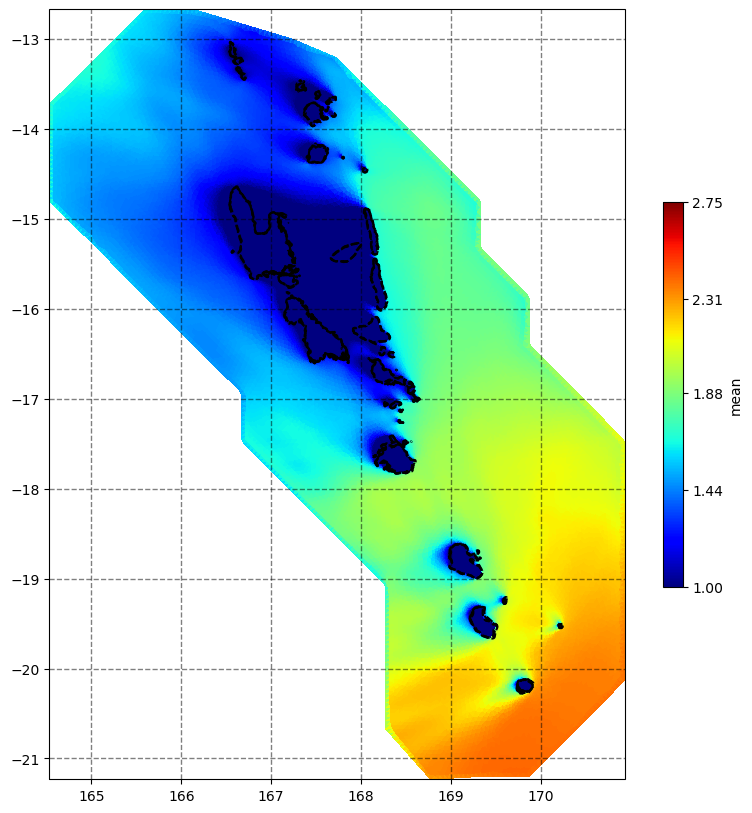

In [37]:
fig, ax = schism_plot(ds_EVA, meshtri,'mean',varscale=[1,2.75], pscale=10,project=True, mask=False)

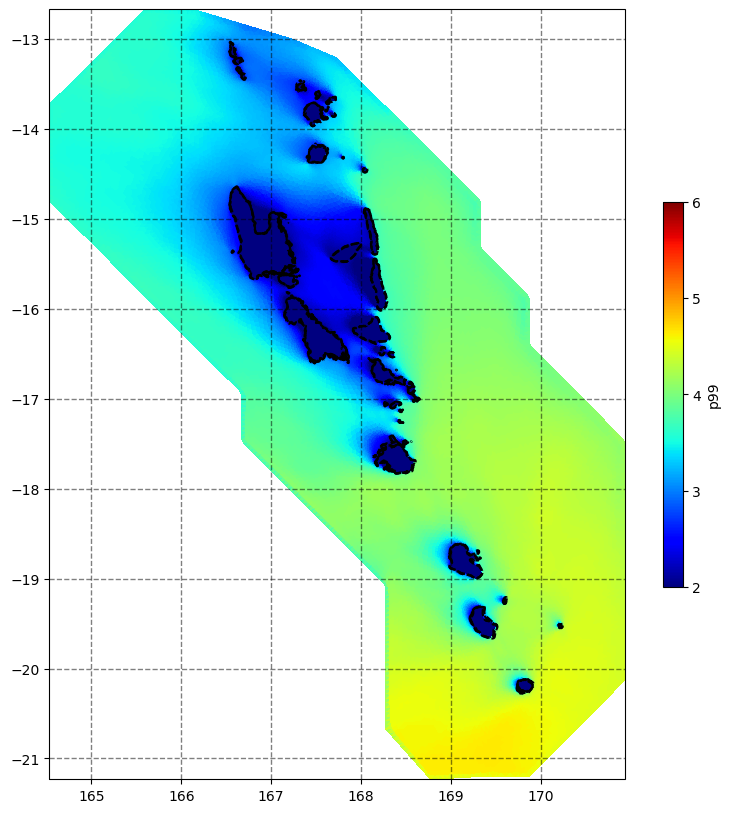

In [38]:
fig, ax = schism_plot(ds_EVA, meshtri,'p99',varscale=[2,6], pscale=10,project=True, mask=False)

(<Figure size 500x500 with 2 Axes>, <GeoAxes: >)

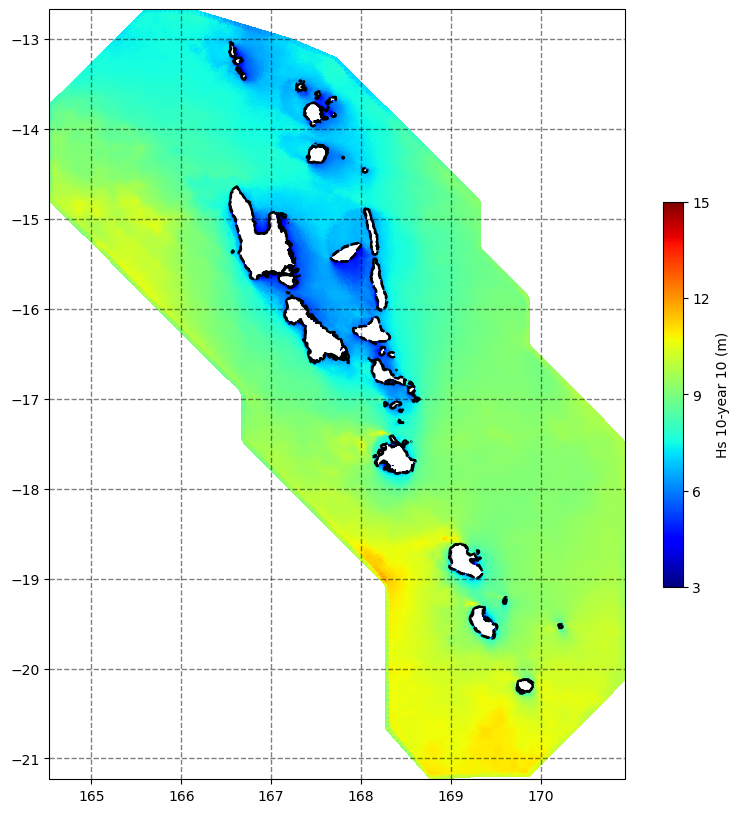

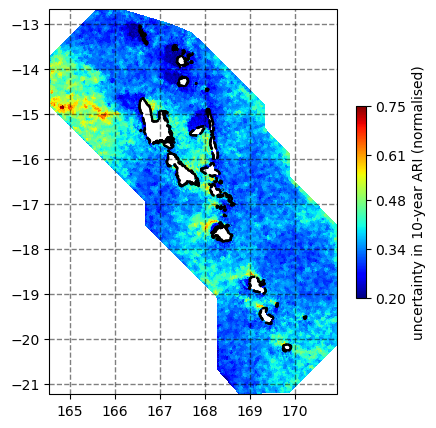

In [39]:
ARI = '10'
fig, ax = schism_plot(ds_EVA, meshtri,ARI,varscale=[3,15], pscale=10,project=True, mask=False, cblabel = f'Hs 10-year {ARI} (m)')
fig.savefig(f'{output_path}/Hindcast_v3_hs_POT_GPD_fit_{ARI}year_ARI.png')

schism_plot(ds_EVA, meshtri,f'{ARI}_uncertainty',varscale=[0.2,.75], pscale=5,project=True, mask=False, cblabel = 'uncertainty in 10-year ARI (normalised)')

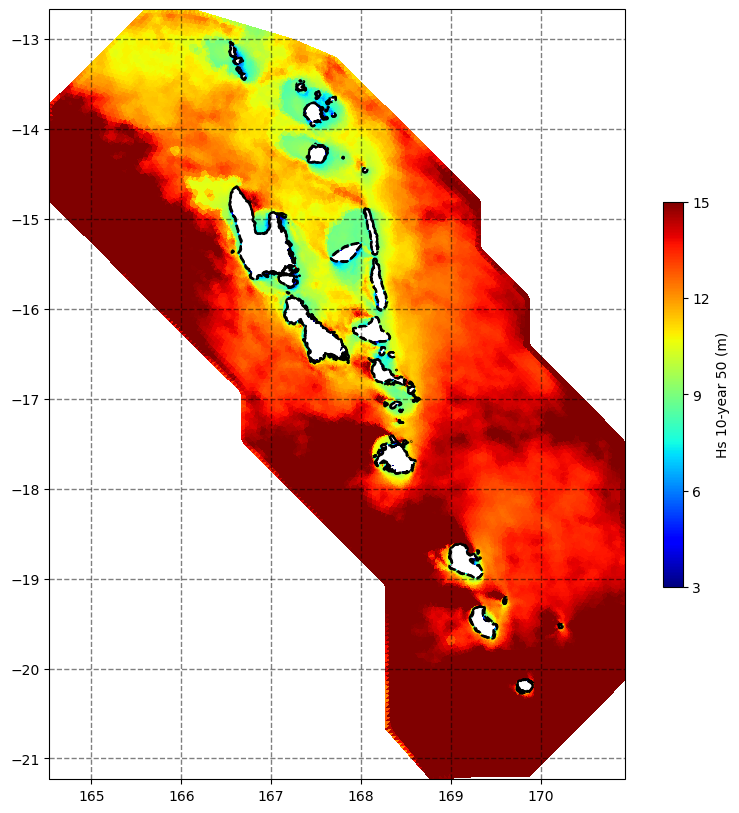

In [40]:
ARI = '50'
fig, ax = schism_plot(ds_EVA, meshtri,ARI,varscale=[3,15], pscale=10,project=True, mask=False, cblabel = f'Hs 10-year {ARI} (m)')
fig.savefig(f'{output_path}/Hindcast_v3_hs_POT_GPD_fit_{ARI}year_ARI.png')

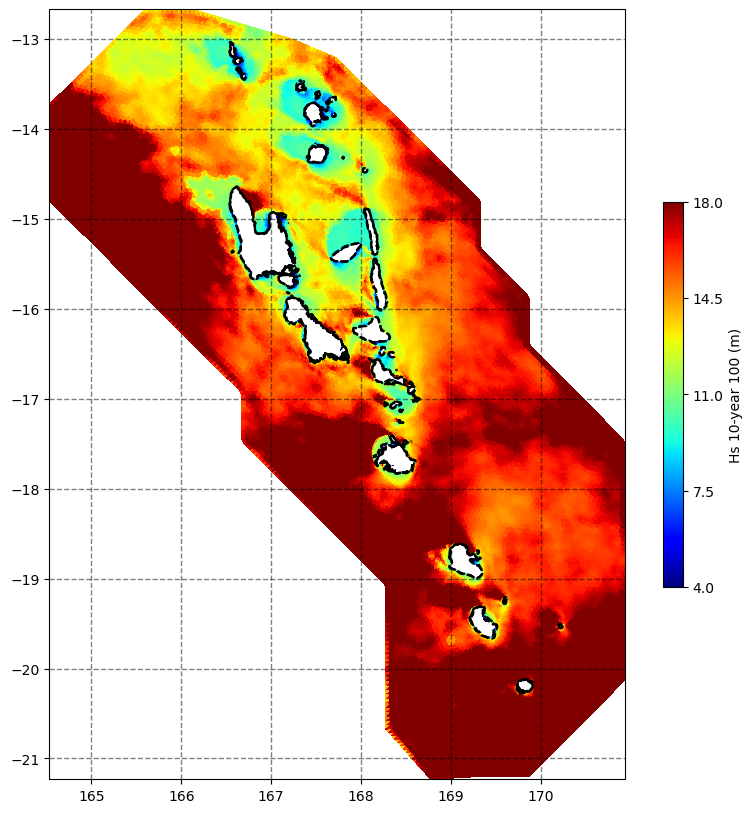

In [42]:
ARI = '100'
fig, ax = schism_plot(ds_EVA, meshtri,ARI,varscale=[4,18], pscale=10,project=True, mask=False, cblabel = f'Hs 10-year {ARI} (m)')
fig.savefig(f'{output_path}/Hindcast_v3_hs_POT_GPD_fit_{ARI}year_ARI.png')

In [50]:
ds_EVA[['mean','max','p99','10','10 lower ci','10 upper ci','50','50 lower ci','50 upper ci','100','100 lower ci','100 upper ci']].to_dataframe()

,mean,max,p99,10,10 lower ci,10 upper ci,50,50 lower ci,50 upper ci,100,100 lower ci,100 upper ci,index
nSCHISM_hgrid_node,,,,,,,,,,,,,
0,1.721851,12.359699,3.647912,9.316660,7.454685,12.587501,18.877153,11.226587,41.510077,26.495507,13.183998,74.190534,0
1,1.723031,12.303158,3.639817,9.016829,7.234186,10.567509,17.120102,9.893044,24.306796,23.221042,11.554429,36.374198,1
2,1.724198,12.290403,3.633357,8.925619,7.159396,11.070208,16.690010,10.890045,30.125857,22.455434,12.964732,48.057707,2
3,1.725296,12.277634,3.625731,8.748211,7.070678,10.289696,15.682008,10.285887,23.913938,20.626510,11.945577,35.449645,3
4,1.726352,12.264853,3.619603,8.702218,7.403272,10.826349,15.475199,10.503540,25.573086,20.266306,12.116911,39.217264,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
100922,2.146669,15.534207,4.185164,9.694605,7.929241,12.475869,17.067412,11.196432,26.909835,22.291248,13.004485,40.033992,2583
100923,2.144143,15.556606,4.180963,9.647697,7.558135,12.128553,16.542506,9.759968,27.323152,21.282211,10.864094,39.944171,2584
100924,2.141544,15.578973,4.176529,9.704033,7.799983,11.710562,16.807989,11.100169,25.828495,21.738762,13.041542,37.733978,2585


In [43]:
ds_EVA

<xarray.Dataset>
Dimensions:                  (nSCHISM_hgrid_node: 100927,
                              nSCHISM_hgrid_face: 201374,
                              nMaxSCHISM_hgrid_face_nodes: 4)
Coordinates:
  * index                    (nSCHISM_hgrid_node) int64 0 1 2 ... 2585 2586 2587
Dimensions without coordinates: nSCHISM_hgrid_node, nSCHISM_hgrid_face,
                                nMaxSCHISM_hgrid_face_nodes
Data variables: (12/21)
    mean                     (nSCHISM_hgrid_node) float32 1.722 1.723 ... 2.136
    max                      (nSCHISM_hgrid_node) float32 12.36 12.3 ... 15.76
    p99                      (nSCHISM_hgrid_node) float64 3.648 3.64 ... 4.173
    c                        (nSCHISM_hgrid_node) float64 0.5581 ... 0.434
    scale                    (nSCHISM_hgrid_node) float64 0.5032 ... 0.6974
    10                       (nSCHISM_hgrid_node) float64 9.317 9.017 ... 9.792
    ...                       ...
    SCHISM_hgrid_node_x      (nSCHISM_hgrid_node) float64 dask.array<chunksize=(100927,), meta=np.ndarray>
    SCHISM_hgrid_node_y      (nSCHISM_hgrid_node) float64 dask.array<chunksize=(100927,), meta=np.ndarray>
    depth                    (nSCHISM_hgrid_node) float32 dask.array<chunksize=(100927,), meta=np.ndarray>
    10_uncertainty           (nSCHISM_hgrid_node) float64 0.5509 ... 0.3636
    50_uncertainty           (nSCHISM_hgrid_node) float64 1.604 ... 0.7942
    100_uncertainty          (nSCHISM_hgrid_node) float64 2.303 1.069 ... 0.9929

In [44]:
sc_ds

<xarray.Dataset>
Dimensions:                  (time: 359424, nSCHISM_hgrid_node: 100927,
                              nSCHISM_hgrid_face: 201374,
                              nMaxSCHISM_hgrid_face_nodes: 4, one: 1,
                              node_idx: 100927)
Coordinates:
  * time                     (time) datetime64[ns] 1980-01-01T01:00:00 ... 20...
  * node_idx                 (node_idx) int64 0 1 2 3 ... 100924 100925 100926
Dimensions without coordinates: nSCHISM_hgrid_node, nSCHISM_hgrid_face,
                                nMaxSCHISM_hgrid_face_nodes, one
Data variables:
    hs                       (time, nSCHISM_hgrid_node) float32 dask.array<chunksize=(1708, 19644), meta=np.ndarray>
    SCHISM_hgrid_face_nodes  (nSCHISM_hgrid_face, nMaxSCHISM_hgrid_face_nodes) float64 dask.array<chunksize=(201374, 4), meta=np.ndarray>
    SCHISM_hgrid_node_x      (nSCHISM_hgrid_node) float64 dask.array<chunksize=(100927,), meta=np.ndarray>
    SCHISM_hgrid_node_y      (nSCHISM_hgrid_node) float64 dask.array<chunksize=(100927,), meta=np.ndarray>
    depth                    (nSCHISM_hgrid_node) float32 dask.array<chunksize=(100927,), meta=np.ndarray>
    minimum_depth            (time, one) float32 dask.array<chunksize=(8784, 1), meta=np.ndarray>
Attributes:
    Conventions:   CF-1.0, UGRID-1.0
    title:         SCHISM Model output
    institution:   SCHISM Model output
    source:        SCHISM model output version v10
    references:    http://ccrm.vims.edu/schismweb/
    history:       created by combine_output11
    comment:       SCHISM Model output
    type:          SCHISM Model output
    VisIT_plugin:  https://schism.water.ca.gov/library/-/document_library/vie...

In [45]:
ds_sc0 = xr.open_dataset(files[0], chunks='auto')

In [46]:
ds_sc0

<xarray.Dataset>
Dimensions:                  (time: 8760, nSCHISM_hgrid_node: 100927,
                              nSCHISM_hgrid_face: 201374,
                              nMaxSCHISM_hgrid_face_nodes: 4, one: 1)
Coordinates:
  * time                     (time) datetime64[ns] 1981-01-01T01:00:00 ... 19...
Dimensions without coordinates: nSCHISM_hgrid_node, nSCHISM_hgrid_face,
                                nMaxSCHISM_hgrid_face_nodes, one
Data variables:
    elev                     (time, nSCHISM_hgrid_node) float32 dask.array<chunksize=(1706, 19667), meta=np.ndarray>
    hs                       (time, nSCHISM_hgrid_node) float32 dask.array<chunksize=(1706, 19667), meta=np.ndarray>
    SCHISM_hgrid_face_nodes  (nSCHISM_hgrid_face, nMaxSCHISM_hgrid_face_nodes) float64 dask.array<chunksize=(201374, 4), meta=np.ndarray>
    SCHISM_hgrid_node_x      (nSCHISM_hgrid_node) float64 dask.array<chunksize=(100927,), meta=np.ndarray>
    SCHISM_hgrid_node_y      (nSCHISM_hgrid_node) float64 dask.array<chunksize=(100927,), meta=np.ndarray>
    depth                    (nSCHISM_hgrid_node) float32 dask.array<chunksize=(100927,), meta=np.ndarray>
    minimum_depth            (one) float32 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    Conventions:   CF-1.0, UGRID-1.0
    title:         SCHISM Model output
    institution:   SCHISM Model output
    source:        SCHISM model output version v10
    references:    http://ccrm.vims.edu/schismweb/
    history:       created by combine_output11
    comment:       SCHISM Model output
    type:          SCHISM Model output
    VisIT_plugin:  https://schism.water.ca.gov/library/-/document_library/vie...